In [1]:
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import Image

%precision 10
%matplotlib inline

# Perceptron Learning Algorithm

## Synthetic Datasets

We will generate a number of data sets. The datapoints $\mathbf{x} = \left(x_1, \cdots, x_d \right)$ have $d$ features with values in the closed interval $[-1, 1]$. Each dataset has $N$ datapoints generated uniformly at random. The dataset is 
separated by the target function $f(\mathbf{x})$ into positive, $f(\mathbf{x})\geq 0$, and negative examples,
$f(\mathbf{x}) < 0$, labeled as $+1$ and $-1$, respectively.

## Generate all datasets at once

The total number of datapoints in one dataset $D$ is $N$:

$$D = \left\{ \mathbf{x}^{(1)}, \cdots,  \mathbf{x}^{(n)}, \cdots, \mathbf{x}^{(N)} \right\}$$ 

Each datapoint $\mathbf{x} = \left(x_1, \cdots, x_d \right)$ has $d$ features $x_1, x_2, \cdots, x_d$.

We add a *dummy feature* $x_0$ that has constant value $1$. This way we ensure that when the data are linear separable the separating hyperplane goes through the origin and it is uniquely characterized by the weight vector that is ortogonal to that hyperplane
$$\sum_{i=0}^{d+1} w_i x_i = \mathbf{w}^\top \mathbf{x} = \mathbf{w} . \mathbf{x}$$

We will generate $\textit{nbsets}$ datasets in total.

In summary, we have

   - $N$ datapoints
   - with $d$ features, and 
   - $nbsets$ datasets

In [2]:
d, N, nbsets = 2, 10, 3

In [3]:
nbpoints = N*nbsets
all_datasets = np.ones(shape=(nbpoints, 1+d))
# All columns apart from the first one contain random numbers uniformly 
# distributed over the interval [-1, 1]
all_datasets[:, 1:] = np.random.uniform(low=-1, high=+1, size=(nbpoints, d))

In [4]:
#all_datasets[:, 1:] = np.random.uniform(low=-1, high=+1, size=nbpoints*d).reshape(nbpoints, d)

## Target function $f$ charachterized by its weight vector $\mathbf{w}_f$

Next, separate the data by the hyperplane characterized by $\mathbf{w}_f^\top = (0, 1, 1)$ and label the data either +1 or -1. 

In other words the **target function** is 
$$f(x_1, x_2) = x_1 + x_2$$

In [5]:
def target_weight(d):
    w = np.ones(shape=1+d)
    w[0] = 0
    return w

In [6]:
W_f = target_weight(d=2)
W_f

array([0., 1., 1.])

## Label all datasets at once using the target function

In [7]:
all_labels = np.sign(all_datasets@W_f.T)

## Or even better, create one function to do all the stuff above.

In [8]:
def generate_data(N, d, nb_sets):
    nb_points = N*nb_sets
    all_datasets = np.ones(shape=(nb_points, 1+d))
    all_datasets[:, 1:] = np.random.uniform(low=-1, high=+1, size=(nb_points, d))
    w_f = target_weight(d)
    all_labels = np.sign(all_datasets@w_f.T)
    return {'Datasets':all_datasets,
            'Labels':all_labels, 
            'Datapoints per set': N,
            'Dimension': d,
            'Sets': nb_sets,
            'Data Generator': w_f}            

## Finally, select one of the datasets as *training set*

In [10]:
def get_training_set(data, idx=0):
    all_datasets, all_labels = data['Datasets'], data['Labels']
    N, nb_sets = data['Datapoints per set'], data['Sets']
    assert idx < nb_sets, 'Not enough sets.'
    offset = N*idx
    return all_datasets[offset:offset+N,:], all_labels[offset:offset+N]

# Plot the training set and the target function

In [9]:
DATA = generate_data(N=25, d=2, nb_sets=10)

In [11]:
X, Y = get_training_set(data=DATA, idx=0)

In [12]:
def get_coords(i, X):
    '''INPUT: the feature index or coordinate i and the dataset X. 
       OUTPUT: '''
    _, dim = X.shape
    assert i < dim
    return X[:, i]

In [13]:
def scatter_data(X, Y, dim1=1, dim2=2):
    positives, negatives = X[Y==+1], X[Y==-1]
    pos_x, pos_y = get_coords(X=positives, i=dim1), get_coords(X=positives, i=dim2)
    neg_x, neg_y = get_coords(X=negatives, i=dim1), get_coords(X=negatives, i=dim2)
    plt.scatter(pos_x, pos_y, color='green')
    plt.scatter(neg_x, neg_y, color='red')

In [14]:
def get_h(w, dim1=1, dim2=2):
    w_0, w_1, w_2 = w[0], w[dim1], w[dim2]
    assert w_2 != 0
    return lambda x : (-1/w_2)*(w_1*x + w_0)

In [15]:
def draw_h(w, dim1=1, dim2=2, color='blue'):
    #dim = len(w)
    #assert dim1 < dim and dim2 < dim
    h = get_h(w=w, dim1=dim1, dim2=dim2)
    x = np.linspace(start=-1.0, stop=1.0, endpoint=True, num=50)
    plt.plot(x, h(x), color)

In [16]:
def plot_training_set(X, Y):
    global W_f
    scatter_data(X, Y, dim1=1, dim2=2)
    draw_h(w=W_f)

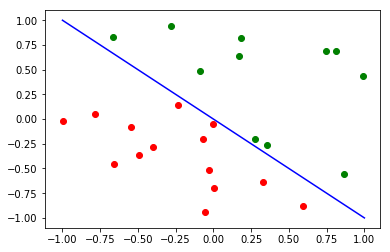

In [30]:
plot_training_set(X, Y)

# Perceptron Learning Algorithm ($\textit{PLA}$)



**Inputs** are the data $X$ and their labels $Y$, the initial weight $w_{init}$, the learning rate $\eta$ and the maximum number of iterations $\textit{max_iter}$. Default values are specified for the later two parameters.

The **output** containts all weights and the index of the last one. If the data could not be separated then the returned index will equal the maximum number of iterations.

## PLA

1. Intialize (randomly) the weight vector $\mathbf{w}_0$
2. Repeat until *no more datapoints are misclassified* or the *maximum number of iterations is reached*
    - At generation $n$ pick a misclassified datapoint $\mathbf{x}_n$ from the dataset $D$
    - Update the weight vector $\mathbf{w}_{n+1} = \mathbf{w}_{n+1} + y_n \mathbf{x}_n$ 
3. Return the final weight vector $\mathbf{w}$

In [17]:
def empty_p(array):
    return array.size == 0
    
def random_datapoint(X, Y):
    nb_points, _ = X.shape
    idx = np.random.randint(nb_points)
    return X[idx], Y[idx]

In [18]:
def match(w, X, Y):
    '''INPUT: weight vector w and the training set with datapoints X and labels Y.
       OUTPUT: in-sample error E_in and the matching results matched_p.'''
    predicted_Y = np.sign(X@w.T)
    matched_p = (predicted_Y != Y)
    E_in = np.sum(matched_p)
    return matched_p, E_in

In [19]:
def random_weight_vector(X):
    _, dim = X.shape
    return np.random.uniform(low=-1, high=+1, size=dim)

In [20]:
def PLA(X, Y, w_init, eta=1, max_iter=1000):
    N, dim = X.shape
    # Create an array to store all weight vectors
    weights = np.zeros(shape=(max_iter, dim))
    E_in_evol = np.zeros(max_iter)
    
    w = np.copy(w_init)
    for n in np.arange(max_iter):
        matched_p, E_in = match(w, X, Y)
        misclassified_X, correct_Y = X[matched_p], Y[matched_p]
        weights[n, :], E_in_evol[n] = w, E_in
        if empty_p(misclassified_X):
            return {'Weights':weights, 'Counter':n, 'In_Sample Error':E_in_evol}
        else:
            misclassified_x, correct_y = random_datapoint(misclassified_X, correct_Y)
            w = w + eta*correct_y*misclassified_x
    else:
        return {'Weights':weights, 'Counter':n, 'In_Sample Error':E_in_evol}

In [21]:
PLA_Result = PLA(X, Y, w_init=random_weight_vector(X), **{'max_iter':1000, 'eta':0.1})

## Run an experiment

In [22]:
def get_final_weights(traces, nb_iters):
    return [trace[last] for trace, last in zip(traces, nb_iters)]

In [23]:
def run(X, Y, learning_alg, nb_runs=10, **params):
    _, dim = X.shape
    traces, nb_iters = [], []
    for i in range(nb_runs):
        result = PLA(X, Y, w_init=random_weight_vector(X), **params)
        traces.append(result['Weights']), nb_iters.append(result['Counter'])
    return get_final_weights(traces, nb_iters), nb_iters

In [24]:
FINAL_WEIGHTS, ITERATIONS = run(X, Y, learning_alg=PLA, 
                                nb_runs=10, **{'max_iter':1000, 'eta':0.01})

In [25]:
ITERATIONS

[159, 110, 160, 126, 56, 173, 70, 204, 96, 161]

# Plot the dataset, target $f$ and the final hypothesis $g$

In [26]:
def plot_run(X, Y, w_f, weights):
    fig, ax = plt.subplots()
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))
    scatter_data(X, Y)
    draw_h(w=W_f)
    for w_final in weights:
        draw_h(w=w_final, color='brown')

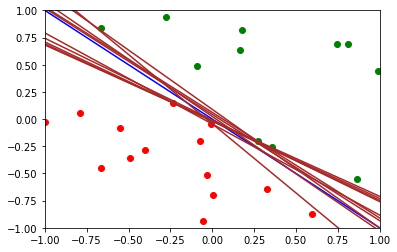

In [27]:
plot_run(X,Y, w_f=W_f, weights=FINAL_WEIGHTS)

# Pocket Algorithm

1. Set the pocket weight vector $\mathbf{w}^*$ to $\mathbf{w}_0$ of PLA
2. for $n = 0, \cdots, N - 1$ do
    - Run PLA for one update to obtain $\mathbf{w}_{n+1}$
    - Evaluate $E_{in} (\mathbf{w}_{n+1})$
    - If $\mathbf{w}_{n+1}$ is better than $\mathbf{w}^*$ in terms of $E_{in}$, set $\mathbf{w}^*$ to $\mathbf{w}_{n+1}$
3. Return $\mathbf{w}^*$

In [28]:
def PocketAlgorithm(X, Y, w_init, eta=1, max_iter=1000):
    N, dim = X.shape
    # Create an array to store all weight vectors
    weights = np.zeros(shape=(max_iter, dim))
    E_in_evol = np.zeros(max_iter)
    # Added to PLA
    best_weights = np.zeros_like(weights)
    E_in_best_evol = np.zeros_like(E_in_evol)
    
    w = np.copy(w_init)
    # Added to PLA
    w_best = w    
    # Added to PLA
    _, E_in_best = match(w, X, Y)                                 
    for n in np.arange(max_iter):
        matched_p, E_in = match(w, X, Y)
        # Added to PLA
        if E_in < E_in_best:                                      
                w_best, E_in_best = w, E_in 
        #print('E_in :', E_in, 'E_in_best :', E_in_best)
        misclassified_X, correct_Y = X[matched_p], Y[matched_p]
        weights[n, :], E_in_evol[n] = w, E_in
        # Added to PLA
        best_weights[n, :], E_in_best_evol[n] = w_best, E_in_best
        if empty_p(misclassified_X):
            return {'Weights':weights, 'Counter':n, 
                    'W_best':w_best, 'E_in_best':E_in_best} 
        else:
            misclassified_x, correct_y = random_datapoint(misclassified_X, correct_Y)
            w = w + eta*correct_y*misclassified_x     
    else:
        return {'Weights':weights, 'Counter':n, 
                'W_best':w_best, 'E_in_best':E_in_best} 

In [29]:
Pocket_Result = PocketAlgorithm(X, Y, w_init=random_weight_vector(X), 
                                **{'eta':2, 'max_iter':10})

# Logistic Regression

The logistic function AKA sigmoid function $\theta$ is defined as
$$\theta(x) = \frac{e^x}{1 + e^x} = \frac{1}{1 + e^{-x}}$$

In [36]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [37]:
## Plot of the sigmoid

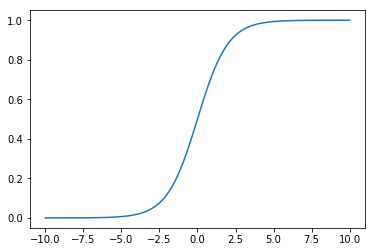

In [38]:
x = np.linspace(-10, 10, 100)
plt.plot(x, sigmoid(x))

# Gradient descent with fixed learning rate $\eta$

1. Initialize the weights at step $n = 0$ to  $\mathbf{w}_0$
2. for $n = 0, \cdots, N - 1$ do
    - Compute the gradient $$\nabla E_{in}(\mathbf{w}_n)$$
    - Update the weights: 
    $$\mathbf{w}_{n+1} = \mathbf{w}_{n+1} - \eta \nabla E_{in}(\mathbf{w}_n)$$
    - Iterate to the next step till *termination criterion* is met
3. Return final the weights  $\mathbf{w}$

# Logistic Regression Algorithm 

1. Initialize the weights at step $n = 0$ to  $\mathbf{w}_0$
2. for $n = 0, \cdots, N - 1$ do
    - Compute the gradient 
    $$\nabla E_{in}(\mathbf{w}_n) = - \frac{1}{N} 
    \sum_{n=1}^{N} \frac{y_n \mathbf{x}_n}{1 + e^{y_n \mathbf{w}.\mathbf{x}_n}}$$
    - Update the weights: 
    $$\mathbf{w}_{n+1} = \mathbf{w}_{n+1} - \eta \nabla E_{in}(\mathbf{w}_n)$$
    - Iterate to the next step till *termination criterion* is met
3. Return final the weights  $\mathbf{w}$

Note that $\nabla E_{in}(\mathbf{w}_n)$ also equals

$$\nabla E_{in}(\mathbf{w}_n) = 
\frac{1}{N} \sum_{n=1}^{N} - y_n \mathbf{x}_n \theta(-y_n \mathbf{w}.\mathbf{x}_n)$$
where $\theta$ is the logistic function 
$$\theta(x) = \frac{1}{1 + e^{-x}}$$

We will use this in the function *gradient_logistic_error*.

In [112]:
def logistic_error(w, X, Y):
    '''INPUT: weight vector w and the training set with datapoints X and labels Y.
       OUTPUT: logistic in-sample error E_in.'''
    E_in = np.average(np.log(1 + np.exp(-Y*(X@w))))
    return E_in

In [113]:
def gradient_logistic_error(w, X, Y):
    arg = -Y*(X@w)
    scalars = -Y*sigmoid(arg)
    scalars = scalars[:, np.newaxis]
    grad = np.mean(scalars*X, axis=0)
    return grad

In [111]:
gradient_logistic_error(w=W_f, X=X, Y=Y)

array([ 0.0523590366, -0.0699268878, -0.1157219771])

In [116]:
def logistic_regression(X, Y, w_init, eta, max_iter):
    N, dim = X.shape
    # Create an array to store all weight vectors
    weights = np.zeros(shape=(max_iter, dim))
    E_in_evol = np.zeros(max_iter)
    w = w_init
    for n in np.arange(max_iter):
        E_in = logistic_error(w, X, Y)
        gradient = gradient_logistic_error(w, X, Y)
        w = w - eta*gradient
        weights[n, :], E_in_evol[n] = w, E_in
    return {'Weights':weights, 'E_in':E_in_evol} 

In [131]:
Result = logistic_regression(X, Y, w_init=random_weight_vector(X), eta=0.1, max_iter=1000)

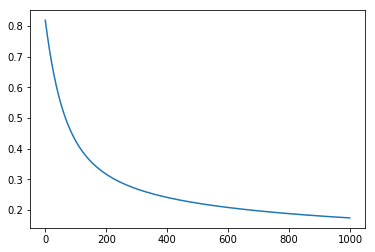

In [132]:
plt.plot(Result['E_in']);

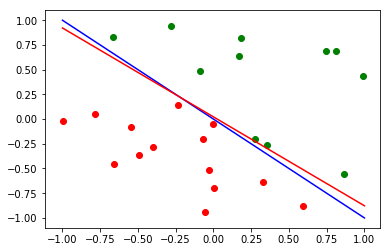

In [133]:
plot_training_set(X, Y)
draw_h(w=Result['Weights'][-1], color='red')

In [152]:
def polar_to_Cartesian(r, theta):
    return r*np.cos(theta), r*np.sin(theta)

In [166]:
def double_demi_circle(rad, sep, thk, N):
    angles = np.random.uniform(low=0., high=2*np.pi, size=N)
    distances = np.random.uniform(low=rad, high=rad+thk, size=N)
    labels = angles<=np.pi
    center_positives, center_negatives = np.zeros(2), np.array([rad+thk/2, -sep])
    x, y = polar_to_Cartesian(r=distances, theta=angles)
    tmp_points = np.vstack((x, y))
    
    return tmp_points, labels  

In [153]:
x, y = polar_to_Cartesian(r=distances,theta=angles)

In [173]:
points, labels = double_demi_circle(rad=10, sep=5, thk=5, N=10)

In [176]:
points

array([[ -0.2467543747,  12.1374665637, -12.3923287146,  -0.589320886 ,
          9.2190993893,   8.7601329348,  10.5400397698,   0.6232702871,
          1.406249733 ,  -6.9839973241],
       [-10.5876213057,  -8.6849379794,   8.4191327166,  10.0017309942,
         -6.3742730687,   8.9795379006,  -5.608011863 ,  10.9340625594,
        -13.2650159233, -11.4665986415]])

In [180]:
np.ones(10).shape

(10,)

In [157]:
points = np.vstack((x, y))

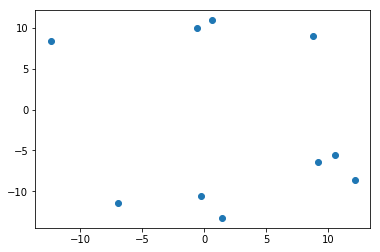

In [174]:
plt.scatter(points[0,:], points[1,:])


# Animation of the decision boundary $h$

Still **To Be Done**

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
line, = ax.plot([], [], lw=2)

In [ ]:
# initialization function: plot the background of each frame
def init():
    global DATA
    scatter_data(X, Y)
    draw_h(w=DATA['Data Generator'])
    line.set_data([], [])
    return line,

In [ ]:
def animate(i):
    global Result
    weights = Result['Weights']
    h = get_h(w=weights[i], dim1=0, dim2=1)
    x = np.linspace(start=-1.0, stop=1.0, endpoint=True, num=50)
    y = h(x)
    plt.plot(x, y, color='brown')
    line.set_data(x, y)
    return line,

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=1)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])